# Random Number Generation
Given a biased coin of unknown bias, can you generate fair random bits? Given such a coin, can you generate random bits with a desired bias? Given a random source of numbers chosen independently and uniformly from $ [0, 1] $, can you generate numbers according to a normal random variable?

This chapter will focus on answering such questions, providing a range of methods varying in simplicity and efficiency.

One can easily discard this chapter without affecting the understanding the rest of the lecture notes, although some of the ideas first discussed in chapter might be helpful in the following chapters.

## Biasing and Unbiasing Coins
We are discussing this subject here, not because it is of use to us, but because the ideas are simple, yet inherently beautiful, and it is related to our subject in its spirit.

### Unbiasing
Here, we will start with the following question:
> Given a possibly biased coin, emulate a fair one!

The idea we will discuss is usually attributed to John von Neumann: throw your coin twice, count "heads then tails" as heads, and "tails then heads" as tails. Repeat on the other two cases!

The two events have probability $ \mathbb{P}(HT \vert \{HT, TH)\} = \mathbb{P}(TH \vert \{HT, TH)\}) = \frac{p(1-p)}{2p(1-p)} = \frac{1}{2} $.

Let's demonstrate the simple process:

(array([ 514.,    0.,  486.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ]),
 <a list of 3 Patch objects>)

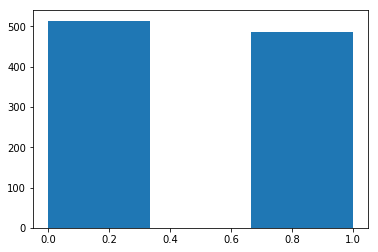

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

bias = 0.7
nSim = 1000

throws = np.zeros(nSim)
for i in range(nSim):
    while True:
        x = 1 if np.random.rand() > bias else 0
        y = 1 if np.random.rand() > bias else 0
        if x != y:
            throws[i] = x
            break

plt.hist(throws, bins=3)

The above process takes $ \frac{1}{p(1-p)} $ throws of the coin to obtain a single bit.

### Biasing
Now, we turn to the opposite problem! Can you build a coin of a given bias? Even an irrational bias? We can of course assume we have a fair coin, since we now know how to unbias it.

> Can you emulate a coin of bias $\frac{1}{\pi}$?

For a given number $ p \in [0, 1] $, write down the binary expansion of $p$. It is obvious that $p = \sum_{i=1}^{\infty} b_i (\frac{1}{2})^i $, where $b_i$s are the numbers in the binary expansion of $p$.

How can that help? We can simulate events of probability $2^{-i}$ using our coin. Just throw the fair coin until the first "heads" comes up! The probability that the process takes $i$ steps is exactly $2^{-i}$. If the first head comes up at $i$th position, return heads if $b_i$ is 1, and return tails otherwise.

The probability of returning heads is by definition $ \sum_{i=1}^{\infty} b_i 2^{-i} = p $.

## Generating Discrete Random Variables
From now on, what we take for granted is a source of independent random numbers chosen uniformly from $ [0, 1] $.

In Python, one can use the `random` function from the `random` package, or the `numpy.random.rand` function, as in the previous code samples. (We will mostly use the later.)

### Bernouli/Binomial Random Variable
This is a the basic case, if $u$ is chosen uniformly from $ [0, 1] $, $\mathbb{P}(u \leq p) = p $. `numpy.random.rand` also takes an argument, the number of samples to return. This leads to the following code to generate a Binomial random variable:

(array([   1.,    5.,   36.,  109.,  181.,  237.,  227.,  133.,   58.,   13.]),
 array([ 440. ,  450.6,  461.2,  471.8,  482.4,  493. ,  503.6,  514.2,
         524.8,  535.4,  546. ]),
 <a list of 10 Patch objects>)

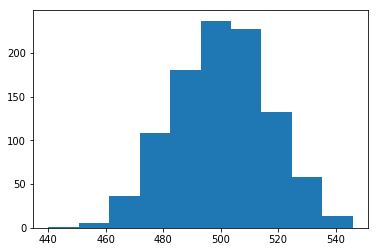

In [2]:
n = 1000
p = 0.5
plt.hist([(np.random.rand(n) > p).sum() for _ in range(1000)], bins=10)

### Discrete Random Variables on Finite Spaces
We want to choose samples of a finite set, given the probability of each member. For example, consider the case of simulating the throw of a single dice. The set will be $\{1,2,3,\dots,6\}$, with probabilities all equal to $\frac{1}{6}$.

Without loss of generality (in the method, not the actual implementation), here we assume that the finite set is the set $\{0,1,2, \dots, n\}$ for some $n$, and the probabilities are given in a vector $[p_0, p_1, \dots, p_n]$.

#### Inverse Function Method
The first method we will discuss is going to divide the unit interval to sectinos of length $p_0, p_1, \dots, p_n$, and return the value assigned to the inteval that $u$ lands in. (We will extend this method to work for random variables on infinite sample spaces as well.)

(array([ 4939.,     0.,  2544.,     0.,     0.,  1265.,     0.,   641.,
            0.,   611.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

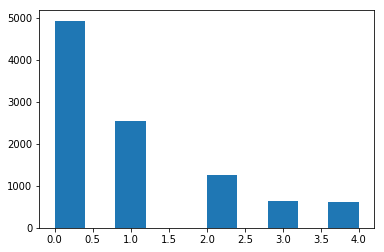

In [3]:
class RV():
    def __init__(self, probs):
        self.intervals = np.cumsum(np.array(probs))
    
    def __call__(self, n=1):
        samples = np.random.rand(n)
        return np.searchsorted(self.intervals, samples)


rv = RV([1/2, 1/4, 1/8, 1/16, 1/16])
plt.hist(rv(10000))

This requires a linear time (in the number of elements of the space) computation before sampling. But taking each sample requires $ \mathcal{O}(log(n)) $ time. In the next sub-section we will discuss the alias method, which enables constant time sampling.

#### Alias Method
Here we will use our ability to generate Bernouli and discrete uniform random variables fast. (I will use `random.choose` for code readability. But generating a uniform random sample is pretty easy.)

Given a distribution on a space of size $n$, We will generate $n-1$ Bernouli random variables, such that choosing one of them uniformly and taking it's outcome results in our desired distribution.

The idea is, knowing that each of the Bernouli random variables are chosen with probability $\frac{1}{n-1}$, there always exists an element of the space with probability less than $\frac{1}{n-1}$ (e.g. an element with minimum probabilit), which guarantees that we can take care of the element in the Bernouli random variable at hand. On the other hand, there always exists an element with probability larger than $\frac{1}{n-1}$, so that we can report the other value of the Bernouli random variable to it and not worry about giving it too much attention. If all this sounds abstract, continue reading with the following example:

Suppose we want to return $0,1$, and $2$ with probabilities respectively $\frac{1}{2}, \frac{1}{4}, \frac{1}{4}$. Take the element with minimum probability, namely $2$, we construct the Bernouli random variable $Q_1$ to return $2$ with probability $\frac{n-1}{1} \mathbb{P}(2) = 2 \frac{1}{4} = \frac{1}{2}$. That means that $2$ will occur with probability at least $\frac{1}{2} \frac{1}{2}$, thus we won't let $2$ appear in any other $Q_i$. We need to decide the other value $Q_1$ returns. It will return it with probability $\frac{1}{2}$, this means that the other value will have a probability of occuring at least $\frac{1}{2} \frac{1}{2} = \frac{1}{4}$. We will use the element with maximum probability, namely $0$. So in conclusion, $Q_1$ will guarantee a final occuring probability of $\frac{1}{4}$ for $0$ and $2$.

So we won't need to worry about $2$ anymore, but $0$ remains open with probability $\frac{1}{4}$. Thus we need to return $1$ or $0$ with probability $\frac{1}{4}$. Thus $Q_2$ returns $0$ or $1$ with equal probability.

The following code implements this idea in general:

[(0, 2, 0.5), (3, 2, 0.5), (4, 2, 0.5), (5, 1, 0.5), (1, 2, 0.5)]


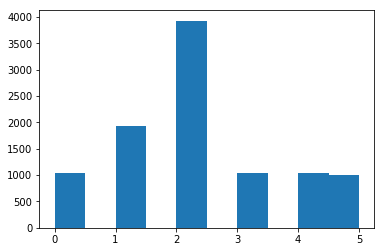

In [9]:
from random import random, choice, seed
seed(1)

class Alias:
    """Implement a random variable using the alias method."""

    def __init__(self, probs):
        """Initiate the object calculating the Q_i s."""
        dist = {i: p for i, p in enumerate(probs)}
        N = len(probs) - 1
        self.Qs = []
        while len(dist) > 1:
            m = min(dist, key=lambda i: dist[i])
            p = dist[m]
            dist.pop(m)
            M = max(dist, key=lambda i: dist[i])
            self.Qs.append((m, M, N * p))
            dist[M] -= (1 - (p * N)) / N

    def sample(self):
        """Return a new sample."""
        s = choice(self.Qs)
        return s[0] if random() < s[2] else s[1]

    def __call__(self):
        return self.sample()


if __name__ == '__main__':
    t = Alias([0.1, 0.2, 0.4, 0.1, 0.1, 0.1])
    print(t.Qs)
    plt.hist([t.sample() for _ in range(10**4)])
    plt.show()